In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

* 1. Data load and simple EDA

In [4]:
df = pd.read_csv("dataset/MNIST_csv/mnist.csv", dtype=np.float32)
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
df.shape

(42000, 785)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: float32(785)
memory usage: 125.8 MB


In [31]:
df['label'].unique()

array([1., 0., 4., 7., 3., 5., 8., 9., 2., 6.], dtype=float32)

In [32]:
df['label'].value_counts()

label
1.0    4684
7.0    4401
3.0    4351
9.0    4188
2.0    4177
6.0    4137
0.0    4132
4.0    4072
8.0    4063
5.0    3795
Name: count, dtype: int64

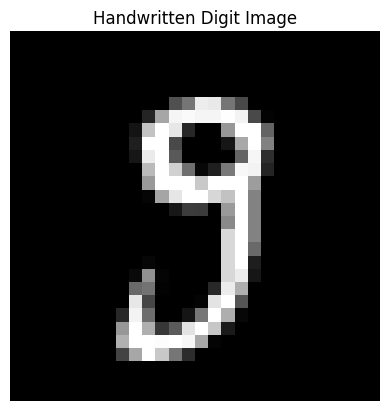

In [33]:
# visualize the dataset
import matplotlib.pyplot as plt

inx = 40
data = df.iloc[inx].to_numpy()
data = data[1:].reshape(28,28)
plt.imshow(data, cmap='gray')
plt.axis("off")
plt.title("Handwritten Digit Image")
plt.show()

* 2. Data processing

In [34]:
from sklearn.model_selection import train_test_split

# Seperate the features and labels
label = df.label.values
features = df.loc[:, df.columns != 'label'].values/255

# Split into training and test set
train_x, test_x, train_y, test_y = train_test_split(features, label, test_size=0.2, random_state=42)

In [35]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


(33600, 784)
(33600,)
(8400, 784)
(8400,)


* 파이토치 모델 학습을 위한 데이터 로더

* 1. Pytorch 데이터로더를 이용하지 않고 바로 불러오기

In [36]:
import time
import math

start = time.time()

batch_size = 64
data_len = len(train_x)
for i in range(0,data_len-batch_size,batch_size):
    j = i+batch_size if i+batch_size<=data_len else data_len
    
    batch_x = torch.FloatTensor(train_x[i:j,:])
    batch_x = batch_x.view(-1,28,28)
    batch_y = torch.LongTensor(train_y[i:j])
    
end = time.time()
print(f'{end-start:.5f} sec')
    

0.01400 sec


* 2. Pytorch 데이터로더 이용하기

In [37]:
from torch.utils.data import DataLoader, Dataset

class custom_data(Dataset):
    def __init__(self, data, targets):
        self.x = data
        self.y = targets
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x[idx])
        x = x.view(-1, 28, 28)
        y = self.y[idx]
        
        return x, y
    
trainset_custom = custom_data(train_x, train_y)

batch = 16

trainloader1 = DataLoader(trainset_custom, batch_size=batch, shuffle=True)

images, label = next(iter(trainloader1))

In [38]:

start = time.time()
bin = 0
for batch, target in trainloader1:
    continue
    
end = time.time()
print(f'{end-start:.5f} sec')
    

0.16252 sec


* 3. 특별한 데이터 처리를 요구하지 않을 때 pytorch 를 이용한 방법

In [44]:
tr_x = torch.from_numpy(train_x)
tr_y = torch.from_numpy(train_y).type(torch.LongTensor) # data type is long

train = torch.utils.data.TensorDataset(tr_x,tr_y)

trainloader = DataLoader(train, batch_size = batch_size, shuffle = True)
img, label = next(iter(trainloader))

In [45]:
start = time.time()
bin = 0
for batch, target in trainloader:
    continue
    
end = time.time()
print(f'{end-start:.5f} sec')

0.12691 sec


* 4. tqdm 을 이용한 방법

In [46]:
from tqdm import tqdm

start = time.time()
bin = 0
for i, (batch, target) in enumerate(tqdm(trainloader)):
    continue
    
end = time.time()
print(f'{end-start:.5f} sec')

100%|██████████| 2100/2100 [00:00<00:00, 16152.17it/s]

0.13101 sec


* 모델 만들기

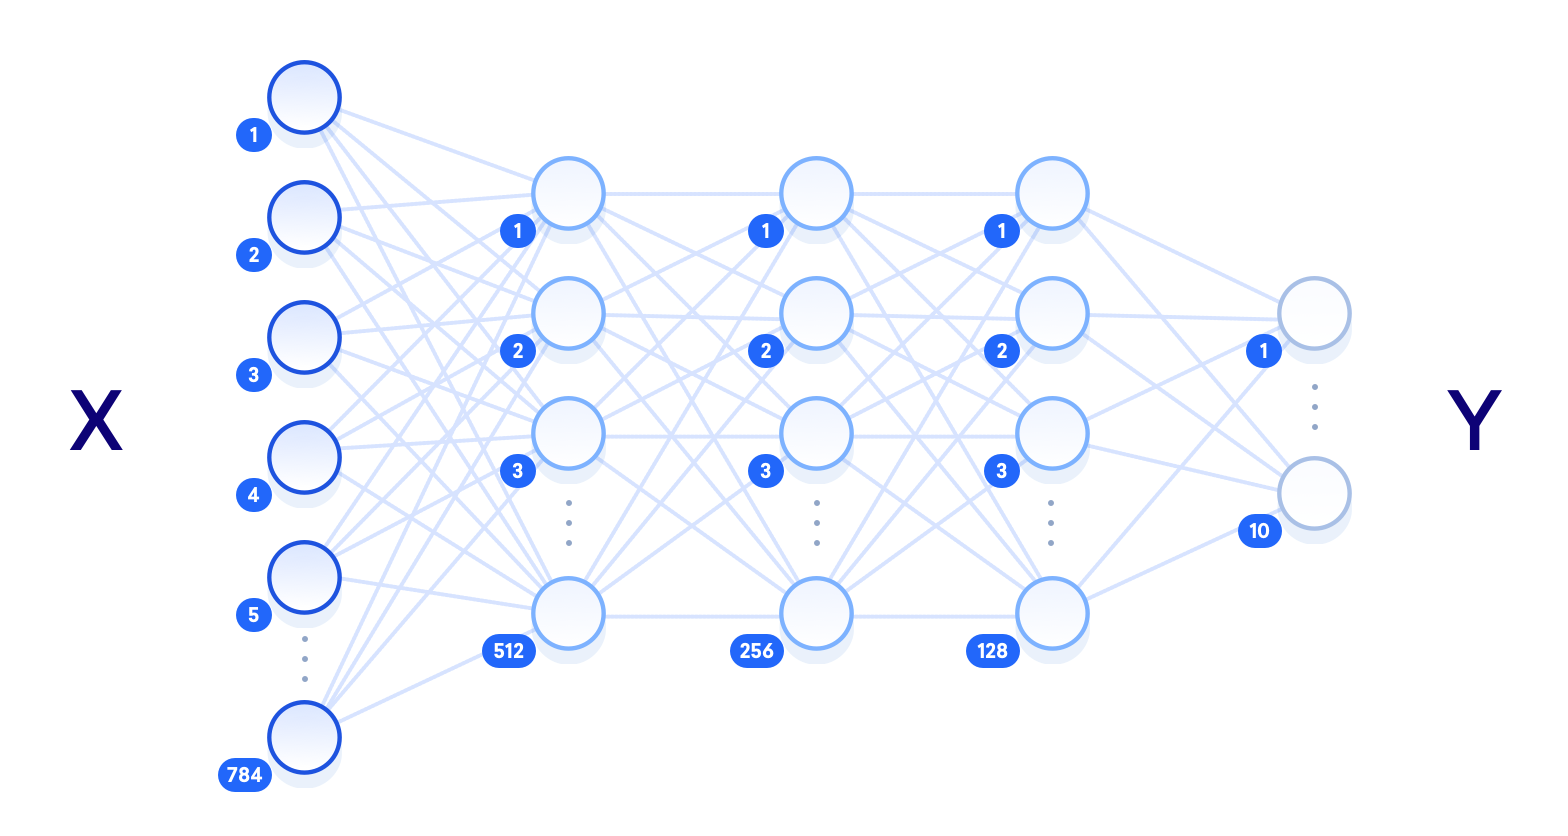

In [54]:
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # 5 Hidden Layer Network
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 10)
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        x = self.fc5(x)
        
        return x
    
model = Classifier()


* 모델의 요약정보 보기


In [55]:
print(model)

Classifier(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
)


* torchsummary 를 이용한 모델의 요약정보 보기

In [56]:
from torchsummary import summary

summary(model, (1, 784), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]         401,920
            Linear-2               [-1, 1, 256]         131,328
            Linear-3               [-1, 1, 128]          32,896
            Linear-4                [-1, 1, 64]           8,256
            Linear-5                [-1, 1, 10]             650
Total params: 575,050
Trainable params: 575,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.19
Estimated Total Size (MB): 2.20
----------------------------------------------------------------


In [57]:
# 데이터 로더 만들기

tr_x = torch.from_numpy(train_x)
tr_y = torch.from_numpy(train_y).type(torch.LongTensor) # data type is long

te_x = torch.from_numpy(test_x)
te_y = torch.from_numpy(test_y).type(torch.LongTensor) # data type is long

train = torch.utils.data.TensorDataset(tr_x,tr_y)
test = torch.utils.data.TensorDataset(te_x,te_y)

# data loader
batch_size = 64
trainloader = DataLoader(train, batch_size = batch_size, shuffle = True)
testloader  = DataLoader(test, batch_size = batch_size, shuffle = False)


In [58]:
# hyperparameter setting & initialize loss function and model

epochs = 25
lr = 0.001
train_loss, test_loss = [], []
steps = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [59]:
for epoch in range(epochs):
    total_loss = 0
    for i, (img, target) in enumerate(tqdm(trainloader)):
        pred = model(img)
        loss = criterion(pred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    if epoch % steps ==0:
        te_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for j, (img, target) in enumerate(testloader):
                pred = model(img)
                te_loss+= criterion(pred, target)
        
        train_loss.append(total_loss/len(trainloader))
        test_loss.append(te_loss/len(testloader))
        
        model.train()
        
        print("Epoch: {}/{}.. ".format(epoch, epochs),
                "Training Loss: {:.3f}.. ".format(train_loss[-1]),
                "Test Loss: {:.3f}.. ".format(test_loss[-1]))
                
                    
                

100%|██████████| 525/525 [00:02<00:00, 251.98it/s]


Epoch: 0/25..  Training Loss: 0.408..  Test Loss: 0.170.. 


100%|██████████| 525/525 [00:02<00:00, 192.01it/s]


Epoch: 5/25..  Training Loss: 0.041..  Test Loss: 0.145.. 


100%|██████████| 525/525 [00:02<00:00, 179.60it/s]


Epoch: 10/25..  Training Loss: 0.024..  Test Loss: 0.127.. 


100%|██████████| 525/525 [00:03<00:00, 174.54it/s]


Epoch: 15/25..  Training Loss: 0.011..  Test Loss: 0.122.. 


100%|██████████| 525/525 [00:03<00:00, 171.14it/s]


Epoch: 20/25..  Training Loss: 0.008..  Test Loss: 0.127.. 


100%|██████████| 525/525 [00:03<00:00, 173.82it/s]


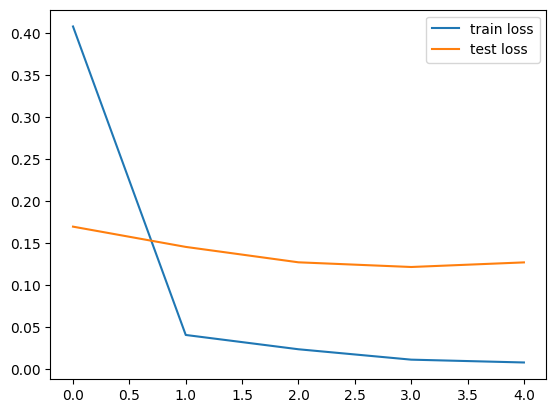

In [60]:
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()

* Accuracy test

In [77]:
from sklearn.metrics import accuracy_score

model.eval()

acc = 0
for j, (img, target) in enumerate(testloader):
    pred = model(img)
    acc+=accuracy_score(target, torch.argmax(pred, axis=1))

acc = acc/(j+1)
print(acc)

0.9719460227272727


* CNN 모델 만들기

In [105]:
import torch.nn.functional as F

# like VGG16

class Classifier_cnn(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        
        self.cnn3 = nn.Conv2d(32, 64,  kernel_size=3, padding=1)
        self.cnn4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.mp = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1,1,28,28)
        x = F.relu(self.cnn1(x))
        x = self.mp(F.relu(self.cnn2(x)))

        x = F.relu(self.cnn3(x))
        x = self.mp(F.relu(self.cnn4(x)))
        
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
model = Classifier_cnn()


In [106]:
from torchsummary import summary
summary(model, (1, 784), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 32, 28, 28]           9,248
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
            Conv2d-5           [-1, 64, 14, 14]          36,928
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
            Linear-8                   [-1, 10]           1,290
Total params: 467,818
Trainable params: 467,818
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 1.78
Estimated Total Size (MB): 2.43
----------------------------------------------------------------


In [107]:
# hyperparameter setting & initialize loss function and model

epochs = 25
lr = 0.001
train_loss, test_loss = [], []
steps = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [108]:
for epoch in range(epochs):
    total_loss = 0
    for i, (img, target) in enumerate(tqdm(trainloader)):
        pred = model(img)
        loss = criterion(pred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    if epoch % steps ==0:
        te_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            for j, (img, target) in enumerate(testloader):
                pred = model(img)
                te_loss+= criterion(pred, target)
        
        train_loss.append(total_loss/len(trainloader))
        test_loss.append(te_loss/len(testloader))
        
        model.train()
        
        print("Epoch: {}/{}.. ".format(epoch, epochs),
                "Training Loss: {:.3f}.. ".format(train_loss[-1]),
                "Test Loss: {:.3f}.. ".format(test_loss[-1]))
                

100%|██████████| 525/525 [00:08<00:00, 64.82it/s]


Epoch: 0/25..  Training Loss: 0.236..  Test Loss: 0.082.. 


100%|██████████| 525/525 [00:09<00:00, 53.43it/s]


Epoch: 5/25..  Training Loss: 0.017..  Test Loss: 0.038.. 


100%|██████████| 525/525 [00:09<00:00, 53.38it/s]


Epoch: 10/25..  Training Loss: 0.009..  Test Loss: 0.037.. 


100%|██████████| 525/525 [00:09<00:00, 53.32it/s]


Epoch: 15/25..  Training Loss: 0.007..  Test Loss: 0.041.. 


100%|██████████| 525/525 [00:09<00:00, 53.16it/s]


Epoch: 20/25..  Training Loss: 0.005..  Test Loss: 0.040.. 


100%|██████████| 525/525 [00:09<00:00, 52.59it/s]


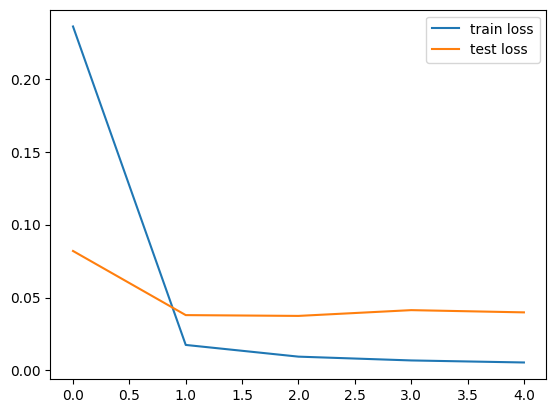

In [109]:
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()

In [110]:
from sklearn.metrics import accuracy_score

model.eval()

acc = 0
for j, (img, target) in enumerate(testloader):
    pred = model(img)
    acc+=accuracy_score(target, torch.argmax(pred, axis=1))

acc = acc/(j+1)
print(acc)

0.9893465909090909
